### Imports

In [112]:
import os
import threading
import tqdm
import time
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import Counter

import numpy as np
import pandas as pd


from rdkit import Chem

import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.data import (
                                    HeteroData,
                                    Data, 
                                    Batch
                                 )   
from torch_geometric.nn import (
                                GATv2Conv,
                                SAGPooling,
                                global_add_pool,
                                HeteroConv,
                                Linear,
                                to_hetero
                                )

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score, 
    precision_recall_curve, 
    auc, 
    average_precision_score, 
    matthews_corrcoef
    )

### Model Definition

#### MHGNN Hetero

In [113]:
class HeteroMHGNN(nn.Module):
    def __init__(self, metadata, in_channels, hidden_dims, heads, use_edge_attr=None):
        super().__init__()
        
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleDict()
        self.skips = nn.ModuleDict()
        self.final_norms = nn.ModuleDict()
        
        # Define which edge types should use edge attributes
        if use_edge_attr is None:
            use_edge_attr = {edge_type: False for edge_type in metadata[1]}
        
        for i, (out_dim, head) in enumerate(zip(hidden_dims, heads)):
            conv_dict = {}
            for edge_type in metadata[1]:
                src, _, dst = edge_type
                if i == 0:
                    in_channels = in_channels
                else:
                    in_channels = hidden_dims[i-1] * heads[i-1]
                
                if use_edge_attr[edge_type]:
                    conv_dict[edge_type] = GATv2Conv(in_channels, out_dim, heads=head, add_self_loops=False, edge_dim=1)
                else:
                    conv_dict[edge_type] = GATv2Conv(in_channels, out_dim, heads=head, add_self_loops=False)
            
            self.convs.append(HeteroConv(conv_dict, aggr='sum'))
            
            for node_type in metadata[0]:
                self.norms[f'{node_type}_{i}'] = nn.LayerNorm(out_dim * head)
                if i == 0:
                    self.skips[f'{node_type}_{i}'] = Linear(in_channels, out_dim * head)
                else:
                    self.skips[f'{node_type}_{i}'] = Linear(hidden_dims[i-1] * heads[i-1], out_dim * head)
        
        self.node_types = metadata[0]
        for node_type in metadata[0]:
            self.final_norms[f'{node_type}'] = nn.LayerNorm(out_dim * head *len(heads))
        
        # Initialize skips with xavier init
        for skip in self.skips.values():
            nn.init.xavier_uniform_(skip.weight)
            nn.init.zeros_(skip.bias)

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        x_repr_dict = {node_type: [] for node_type in self.node_types}
        # edge_attr_dict = {key: value.to(torch.float32) for key, value in edge_attr_dict.items()}

        
        for i, conv in enumerate(self.convs):
            skip_x = {}
            for node_type in self.node_types:
                skip_x[node_type] = self.skips[f'{node_type}_{i}'](x_dict[node_type])
            
            x_dict_new = conv(x_dict, edge_index_dict, edge_attr_dict)
            
            for node_type in self.node_types:
                # skip_x = self.skips[f'{node_type}_{i}'](x_dict[node_type])
                x = x_dict_new[node_type]
                x = self.norms[f'{node_type}_{i}'](x) + skip_x[node_type]
                x = self.norms[f'{node_type}_{i}'](x)
                x = F.elu(x)
                x_repr_dict[node_type].append(x)
                x_dict[node_type] = x
        
        # Concatenate all representations for each node type
        for node_type in self.node_types:
            x_repr_dict[node_type] = self.final_norms[f'{node_type}'](torch.cat(x_repr_dict[node_type], dim=1))
        
        return x_repr_dict

# Specify which edge types should use edge attributes
use_edge_attr = {
    ('drug', 'known', 'side_effect'): False,
    ('drug', 'struct', 'drug'): True,
    ('drug', 'word', 'drug'): True,
    ('drug', 'target', 'drug'): True,
    ('drug', 'se_encoded', 'drug'): True,
    ('side_effect', 'name', 'side_effect'): True,
    ('side_effect', 'dg_encoded', 'side_effect'): True,
    ('side_effect', 'atc', 'side_effect'): True,
    ('side_effect', 'rev_known', 'drug'): False
}


#### DVModel

In [114]:
class DrugInterView_Block(nn.Module):
    def __init__(self, n_heads, in_features, head_out_feats):
        super().__init__()
        self.n_heads = n_heads
        self.in_features = in_features
        self.out_features = head_out_feats

        self.feature_conv = GATv2Conv(in_features, head_out_feats, n_heads, edge_dim=6)

        self.readout = SAGPooling(n_heads * head_out_feats, min_score=-1)

    def forward(self, mol_data):
        mol_data.x = self.feature_conv(mol_data.x, mol_data.edge_index, mol_data.edge_attr)
        mol_data_att_x, att_edge_index, att_edge_attr, h_att_batch, att_perm, h_att_scores = self.readout(mol_data.x, mol_data.edge_index, batch=mol_data.batch)

        mol_data_global_graph_emb = global_add_pool(mol_data_att_x, h_att_batch)

        return mol_data, mol_data_global_graph_emb, h_att_scores, h_att_batch

In [115]:
class FinalDrugMolEmb(nn.Module):
    def __init__(self, in_features, heads_out_feat_params, blocks_params):
        super().__init__()
        self.in_features = in_features
        self.n_blocks = len(blocks_params)

        self.inital_norm = nn.LayerNorm(self.in_features)

        self.blocks = nn.ModuleList()
        self.net_norms = nn.ModuleList()

        for i, (head_out_feats, n_heads) in enumerate(zip(heads_out_feat_params, blocks_params)):
            block = DrugInterView_Block(n_heads, in_features, head_out_feats)
            self.blocks.append(block)
            self.net_norms.append(nn.LayerNorm(head_out_feats * n_heads))
            in_features = head_out_feats * n_heads
       
    def forward(self, mol_data):
        repr_mol = []
        mol_data.x = self.inital_norm(mol_data.x)
        attention_weights = []
        attention_batch = []
        for idx, (block, norm) in enumerate(zip(self.blocks, self.net_norms)):
            mol_data, mol_data_global_graph_emb, mol_data_att_x, h_att_batch = block(mol_data)
            attention_weights.append(mol_data_att_x)
            attention_batch.append((mol_data.batch, h_att_batch))
            repr_mol.append(mol_data_global_graph_emb)
            if idx < len(self.blocks) - 1:
                mol_data.x = F.elu(norm(mol_data.x))
        # concat all the global graph embeddings
        mol_data_global_graph_emb = torch.cat(repr_mol, dim=1)
        return mol_data_global_graph_emb, attention_weights, attention_batch

In [116]:
class DVModel(torch.nn.Module):
    def __init__(self, hidden_channels, gnn_model, classifier_model, use_node_features=False, node_feature_mode="no", return_features=False):
        super().__init__()
        # Instantiate node embeddings:
        self.seff_emb = torch.nn.Embedding(data["side_effect"].num_nodes, hidden_channels)
        # DV for Drug
        self.drug_emb = FinalDrugMolEmb(in_features=55, heads_out_feat_params=[64, 64], blocks_params=[3, 3])
        outer_emb_dim = 2 * 64 * 3
        self.inital_norm_outer_drug = nn.LayerNorm(outer_emb_dim)
        self.inital_norm_outer_se = nn.LayerNorm(outer_emb_dim)
        # Instantiate Outer GNNs
        self.gnn = gnn_model # outer message passing
        self.use_node_features = use_node_features
        self.node_feature_mode = node_feature_mode  # combine, feat
        if use_node_features:
            self.drug_feat_layernorm = torch.nn.LayerNorm(data["drug"].num_features)
            self.drug_lin = torch.nn.Linear(data["drug"].num_features, hidden_channels)
        # Instantiate classifier:
        self.classifier = classifier_model
        self.return_features = return_features
        torch.nn.init.xavier_uniform_(self.seff_emb.weight)
        
    def __create_graph_data(self, drug_ids, device):
        drug_ids_ = drug_ids.cpu().numpy().astype(int).tolist()
        final_data = []
        for id in drug_ids_:
            _ = MOL_EDGE_LIST_FEAT_MTX[id]
            final_data.append(Data(x= _[1]  , edge_index=_[0], edge_attr=_[2]))
        return Batch.from_data_list(final_data).to(device)        
       
    
    def forward(self, data: HeteroData) -> Tensor:
        if self.use_node_features:
            if self.node_feature_mode=="feat":
                x_dict = {
                    "drug": self.drug_lin(self.drug_feat_layernorm(data["drug"].x)),
                    "side_effect": self.seff_emb(data["side_effect"].node_id)
                }
        else:
            drug_list_of_graph_data = self.__create_graph_data(data["drug"].node_id, data["drug"].node_id.device)
            
            drug_dv, attention_weights, h_att_batch = self.drug_emb(drug_list_of_graph_data)
            if self.node_feature_mode=="combined":
                drug_dv += self.drug_lin(self.drug_feat_layernorm(data["drug"].x))
            
            # layer normalization of input features for outer gnn:
            x_dict = {
                "drug":  self.inital_norm_outer_drug(drug_dv),
                "side_effect": self.inital_norm_outer_se(self.seff_emb(data["side_effect"].node_id))
            }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        # x_dict = self.gnn(x_dict, data.edge_index_dict, data.edge_attr_dict)
        # Forward pass
        x_dict = self.gnn(x_dict, data.edge_index_dict, data.edge_attr_dict)
        pred = self.classifier(
            x_dict["drug"],
            x_dict["side_effect"],
            data["drug", "known", "side_effect"].edge_label_index,
        )
        if self.return_features:
            return pred, attention_weights, h_att_batch, x_dict
        else:
            return pred, attention_weights, h_att_batch

#### Edge Classifier

In [117]:
# Our final classifier applies the hammard-product between source and destination
# node embeddings to derive edge-level predictions:
class VanillaClassifier(torch.nn.Module):
    def forward(self, x_drug: Tensor, x_se: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_drug = x_drug[edge_label_index[0]]
        edge_feat_se = x_se[edge_label_index[1]]

        # Apply hammard-product to get a prediction per supervision edge:
        return (edge_feat_drug * edge_feat_se).sum(dim=-1)

### Load Data

In [118]:
# data_dict = data.to_dict()
fnm = '../prep_data/hetero_graph/hetero_data_dict.pt'
data = torch.load(fnm)

### Load Transformation Maps

In [119]:
DB_TO_ID_DICT = {}
drug_id_mol_graph_tup = []
ID_TO_DB_DICT = {}
MEDRAID_TO_ID_DICT = {}
ID_TO_MEDRAID_DICT = {}

In [120]:
dict_list = [DB_TO_ID_DICT, ID_TO_DB_DICT, MEDRAID_TO_ID_DICT, ID_TO_MEDRAID_DICT, drug_id_mol_graph_tup]
file_names = ['db_to_id.pt', 'id_to_db.pt', 'uml_to_id.pt', 'id_to_uml.pt', 'drug_to_mol.pt']

for data_dict, fnm in zip(dict_list, file_names):
    full_path = f"../prep_data/hetero_graph/{fnm}"
    loaded_data = torch.load(full_path)
    
    if isinstance(data_dict, dict):
        data_dict.update(loaded_data)
    elif isinstance(data_dict, list):
        data_dict.extend(loaded_data)
    else:
        # If it's neither a dict nor a list, just replace it
        index = dict_list.index(data_dict)
        dict_list[index] = loaded_data

### HeteroData Undirected

In [121]:
data = T.ToUndirected()(data)

### Molecule Featurization Utils

In [122]:
# Bond featurization
def get_bond_features(bond):
    # Simplified list of bond types
    permitted_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, 
                            Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC, 'Unknown']
    bond_type = bond.GetBondType() if bond.GetBondType() in permitted_bond_types else 'Unknown'
    
    # Features: Bond type, Is in a ring
    features = one_of_k_encoding_unk(bond_type, permitted_bond_types) \
               + [bond.IsInRing()]
    
    return np.array(features, dtype=np.float32)

def get_mol_edge_list_and_feat_mtx(mol_graph):
    n_features = [(atom.GetIdx(), atom_features(atom)) for atom in mol_graph.GetAtoms()]
    n_features.sort() # to make sure that the feature matrix is aligned according to the idx of the atom
    _, n_features = zip(*n_features)
    # n_features = torch.stack(n_features)
    n_features = torch.tensor(n_features, dtype=torch.float32)

    edge_list = torch.LongTensor([(b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in mol_graph.GetBonds()])
    undirected_edge_list = torch.cat([edge_list, edge_list[:, [1, 0]]], dim=0) if len(edge_list) else edge_list 

    # Extract bond features
    bond_features = [get_bond_features(bond) for bond in mol_graph.GetBonds()]
    undirected_bond_features = bond_features + bond_features  # duplicate for undirected edges
    edge_attr = torch.tensor(undirected_bond_features, dtype=torch.float32)

    return undirected_edge_list.T, n_features, edge_attr 


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def all_of_k_encoding_unk(x, allowable_set):
    enc = np.zeros(len(allowable_set))
    for idx, side_eff_id in enumerate(allowable_set):
        if side_eff_id in x:
            enc[idx] = 1
    return enc
    
def atom_features(atom,
                explicit_H=True,
                use_chirality=False):

    results = one_of_k_encoding_unk(
        atom.GetSymbol(),
        ['C','N','O', 'S','F','Si','P', 'Cl','Br','Mg','Na','Ca','Fe','As','Al','I','B','V','K','Tl',
            'Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn','H', 'Li','Ge','Cu','Au','Ni','Cd','In',
            'Mn','Zr','Cr','Pt','Hg','Pb','Unknown'
        ]) + [atom.GetDegree()/10, atom.GetImplicitValence(), 
                atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
                one_of_k_encoding_unk(atom.GetHybridization(), [
                Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
                                    SP3D, Chem.rdchem.HybridizationType.SP3D2
                ]) + [atom.GetIsAromatic()]
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if explicit_H:
        results = results + [atom.GetTotalNumHs()]

    if use_chirality:
        try:
            results = results + one_of_k_encoding_unk(
            atom.GetProp('_CIPCode'),
            ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
        except:
            results = results + [False, False
                            ] + [atom.HasProp('_ChiralityPossible')]

    results = np.array(results).astype(np.float32)

    return results #torch.from_numpy(results)

### Molecule Featurization

In [123]:
MOL_EDGE_LIST_FEAT_MTX = {DB_TO_ID_DICT[drug_id]: get_mol_edge_list_and_feat_mtx(mol) 
                                for drug_id, mol in drug_id_mol_graph_tup}
len(MOL_EDGE_LIST_FEAT_MTX.keys())

1007

In [124]:
MOL_EDGE_LIST_FEAT_MTX[998][1].shape, MOL_EDGE_LIST_FEAT_MTX[998][2].shape

(torch.Size([57, 55]), torch.Size([16, 6]))

### Analysis batch data

In [125]:
def get_analysis_data(data, num_neighbors=[10, 4], batch_size=64):
    # get all known assoication edges and random negative links to analyse the learn vector representation
    transform = T.RandomLinkSplit(
            num_val=0.0,
            num_test=0.0,
            disjoint_train_ratio=0.99,
            neg_sampling_ratio=1.0,
            add_negative_train_samples=True,
            edge_types=('drug', 'known', 'side_effect'),
            rev_edge_types=('side_effect', 'rev_known', 'drug'), 
        )
    analysis_data, _, _ = transform(data)    
    # Define seed edges:
    edge_label_index = analysis_data['drug', 'known', 'side_effect'].edge_label_index
    edge_label = analysis_data['drug', 'known', 'side_effect'].edge_label

    # return full batch
    batch = Batch.from_data_list([analysis_data])
    
    return batch

In [126]:
def mrank(y, y_pre):
    index = np.argsort(-y_pre)
    r_label = y[index]
    r_index = np.array(np.where(r_label == 1)) + 1
    reci_sum = np.sum(1 / r_index)
    reci_rank = np.mean(1 / r_index)
    return reci_sum

def final_embed_and_stats(batch, model, device, ret=False):
    model.eval()
    with torch.no_grad():
        batch.to(device)
        pred, _, _, x_dict = model(batch) 
        # Applying sigmoid activation function to the predicted values
        preds = torch.sigmoid(pred)

        ground_truths = batch["drug", "known", "side_effect"].edge_label

    pred = preds.cpu().numpy()
    pred_int = (pred>0.5).astype(int)
    ground_truth = ground_truths.cpu().numpy()

    auc = roc_auc_score(ground_truth, pred)
    ap = average_precision_score(ground_truth, pred)
    mr = mrank(ground_truth, pred)
    f1 = f1_score(ground_truth, pred_int)
    mcc = matthews_corrcoef(ground_truth, pred_int)
    acc = (pred_int == ground_truth).mean()
    precision = precision_score(ground_truth, pred_int)
    recall = recall_score(ground_truth, pred_int)
    print()
    print(f"Full Data AUC: {auc:.4f}")
    print(f"Full Data AP: {ap:.4f}")
    print(f"Full Data F1: {f1:.4f}")
    print(f"Full Data Accuracy: {acc:.4f}")
    print(f"Full Data Precission: {precision:.4f}")
    print(f"Full Data Recall: {recall:.4f}")
    print(f"Full Data MCC: {mcc:.4f}")
    print(f"Full Data MR: {mr:.4f}")

    edge_label_index = analysis_loader['drug', 'known', 'side_effect']['edge_label_index']
    edge_label = analysis_loader['drug', 'known', 'side_effect']['edge_label']
    if ret:
        return auc, ap, f1, acc, precision, recall, mr, mcc, x_dict
    return x_dict, edge_label_index, edge_label


### Load Model State

In [127]:
gnn_model = HeteroMHGNN(data.metadata(), in_channels=384, hidden_dims=[64, 64, 64], heads=[2, 2, 2], use_edge_attr=use_edge_attr)
classifier_model = VanillaClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DVModel(hidden_channels=384, gnn_model=gnn_model,
                classifier_model=classifier_model, use_node_features=False, return_features=True)

model = model.to(device)


In [128]:
model_name = f"sdv-hgnn-outer-skip/fold4"

In [129]:
model.load_state_dict(torch.load(f'saved_models/{model_name}/best_model.pth'))

<All keys matched successfully>

### Analyse on Test Loader

In [130]:
analysis_loader = get_analysis_data(data, num_neighbors=[10, 4], batch_size=64)

In [131]:
x_dict, edge_label_index, edge_label = final_embed_and_stats(analysis_loader, model, device)


Full Data AUC: 0.9091
Full Data AP: 0.8981
Full Data F1: 0.8422
Full Data Accuracy: 0.8445
Full Data Precission: 0.8546
Full Data Recall: 0.8302
Full Data MCC: 0.6893
Full Data MR: 11.2473


In [132]:
x_dict

{'drug': tensor([[ 0.3534, -0.6646, -0.0592,  ..., -0.0846,  1.7940, -0.5221],
         [ 0.5439, -0.6494, -0.0612,  ..., -0.0858,  1.7896, -0.5413],
         [ 0.3620, -0.6346, -0.0592,  ..., -0.0862,  1.8477, -0.5002],
         ...,
         [ 0.3354, -0.7299, -0.0593,  ..., -0.0833,  1.4605, -0.4591],
         [ 0.2912, -0.7144, -0.0578,  ..., -0.0850,  1.3518, -0.4436],
         [ 0.3071, -0.7235, -0.0610,  ..., -0.0851,  1.3542, -0.4477]],
        device='cuda:0'),
 'side_effect': tensor([[-0.0149, -1.0595,  0.0570,  ...,  0.0449, -0.9191, -0.4965],
         [-0.0358, -0.0691,  0.0379,  ..., -0.0129, -0.9024, -0.5426],
         [-0.0206, -0.5052,  0.1181,  ..., -0.0096, -0.9300, -0.4696],
         ...,
         [ 0.0120,  3.5430,  0.0848,  ...,  0.0846, -0.7845, -0.5188],
         [-0.0494,  3.6664, -0.0076,  ...,  0.0804, -0.7590, -0.5009],
         [-0.0859,  3.6413,  0.0170,  ...,  0.0802, -0.7905, -0.5011]],
        device='cuda:0')}

### Plot Positive and Negative Edges

In [22]:
# ! pip install umap-learn==0.5.1

#### Try UMAP, TSNE, PCA

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import umap
# import torch
# import warnings
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# def plot_edge_representations(x_dict, edge_label_index, edge_label, n_components=2, method='umap', subsample_size=10000):
#     # Get node embeddings
#     x_drug, x_se = x_dict['drug'].cpu(), x_dict['side_effect'].cpu()
#     edge_label_index, edge_label = edge_label_index.cpu(), edge_label.cpu()
    
#     # Compute edge representations (Hadamard product)
#     edge_feat_drug = x_drug[edge_label_index[0]]
#     edge_feat_se = x_se[edge_label_index[1]]
#     edge_representations_hadamard = edge_feat_drug * edge_feat_se
    
#     # Compute sum and apply sigmoid for predictions
#     edge_sum = torch.sum(edge_representations_hadamard, dim=-1)
#     edge_predictions = torch.sigmoid(edge_sum)
    
#     # Convert to numpy
#     edge_representations_hadamard = edge_representations_hadamard.detach().numpy()
#     edge_predictions = edge_predictions.detach().numpy()
#     edge_labels = edge_label.numpy()
    
#     # Subsample if needed
#     if subsample_size is not None and edge_representations_hadamard.shape[0] > subsample_size:
#         indices = np.random.choice(edge_representations_hadamard.shape[0], subsample_size, replace=False)
#         edge_representations_hadamard = edge_representations_hadamard[indices]
#         edge_predictions = edge_predictions[indices]
#         edge_labels = edge_labels[indices]
    
#     # Standardize the features
#     # scaler = StandardScaler()
#     # edge_representations_scaled = scaler.fit_transform(edge_representations_hadamard)
#     # # Step 1: PCA
#     pca = PCA(
#             n_components=100,
#             svd_solver='randomized',  # Efficient for large datasets
#             random_state=42,  # For reproducibility
#             # iterated_power=5,  # Increase for potentially better accuracy, at the cost of speed
#             whiten=False  # Set to True if you want to normalize the variance of components
#         )

#     edge_representations_scaled = pca.fit_transform(edge_representations_hadamard)

#     # edge_representations_scaled = edge_representations_hadamard
    
#     # Dimensionality reduction
#     if method == 'pca':
#         reducer = PCA(n_components=n_components)
#         x_label, y_label = "Component1", "Component2"
#     elif method == 'tsne':
#         reducer = TSNE(n_components=n_components, random_state=42, n_jobs=-1, init='pca', learning_rate='auto')
#         x_label, y_label = "t-SNE Component 1", "t-SNE Component 2"
#     elif method == 'umap':
#         reducer = umap.UMAP(
#             n_components=n_components,
#             n_neighbors=12,
#             min_dist=0.4,
#             metric='cosine', #correlation',
#             random_state=69,
#             # low_memory=True
#         )
#         x_label, y_label = "UMAP 1", "UMAP 2"
#     else:
#         raise ValueError("Method must be either 'pca', 'tsne', or 'umap'")
    
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", category=UserWarning)
#         edge_representations_2d = reducer.fit_transform(edge_representations_scaled)
    
#      # Plotting True Labels
#     # plt.figure(figsize=(14, 12))
    
#     pos_mask = edge_labels == 1
#     neg_mask = edge_labels == 0
    
#     # plt.scatter(edge_representations_2d[neg_mask, 0], edge_representations_2d[neg_mask, 1], 
#     #             c='blue', marker='o', s=30, alpha=0.7, label='Negative (True)')
#     # plt.scatter(edge_representations_2d[pos_mask, 0], edge_representations_2d[pos_mask, 1], 
#     #             c='red', marker='^', s=30, alpha=0.7, label='Positive (True)')
    
#     # plt.title('Edge Representations (True Labels)', fontsize=18)
#     # plt.xlabel(x_label, fontsize=16)
#     # plt.ylabel(y_label, fontsize=16)
#     # plt.legend(fontsize=14, loc='best')
    
#     # plt.tick_params(axis='both', which='major', labelsize=12)
    
#     # plt.tight_layout()
#     # plt.show()
    
#     # Plotting Model Predictions
#     plt.figure(figsize=(14, 12))
    
#     # Use a colormap that transitions from blue to red
#     cmap = plt.cm.coolwarm
    
#     plt.scatter(edge_representations_2d[neg_mask, 0], edge_representations_2d[neg_mask, 1], 
#                 c=edge_predictions[neg_mask], marker='o', s=30, alpha=0.7, label='Negative (True)', cmap=cmap)
#     plt.scatter(edge_representations_2d[pos_mask, 0], edge_representations_2d[pos_mask, 1], 
#                 c=edge_predictions[pos_mask], marker='^', s=30, alpha=0.7, label='Positive (True)', cmap=cmap)
    
#     # scatter = plt.scatter(edge_representations_2d[:, 0], edge_representations_2d[:, 1], 
#     #                       c=edge_predictions, s=30, alpha=0.7, cmap=cmap,
#     #                       marker='o')  # Use 'o' for all predictions
    
#     plt.title('Edge Representations (Model Predictions)', fontsize=18)
#     plt.xlabel(x_label, fontsize=16)
#     plt.ylabel(y_label, fontsize=16)
#     plt.legend(fontsize=14, loc='best')
    
#     plt.tick_params(axis='both', which='major', labelsize=12)
    
#     # Add colorbar with custom ticks
#     cbar = plt.colorbar(ticks=[0, 0.25, 0.5, 0.75, 1])
#     cbar.ax.set_yticklabels(['0 (Negative)', '0.25', '0.5', '0.75', '1 (Positive)'], fontsize=12)
#     cbar.set_label('Prediction Probability', fontsize=14)
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print statistics
#     print(f"Total points: {len(edge_labels)}")
#     print(f"Class 0 (Negative) points: {np.sum(edge_labels == 0)}")
#     print(f"Class 1 (Positive) points: {np.sum(edge_labels == 1)}")

# # Usage example
# # plot_edge_representations(x_dict, edge_label_index, edge_label, method='umap', subsample_size=10000)


##### UMAP

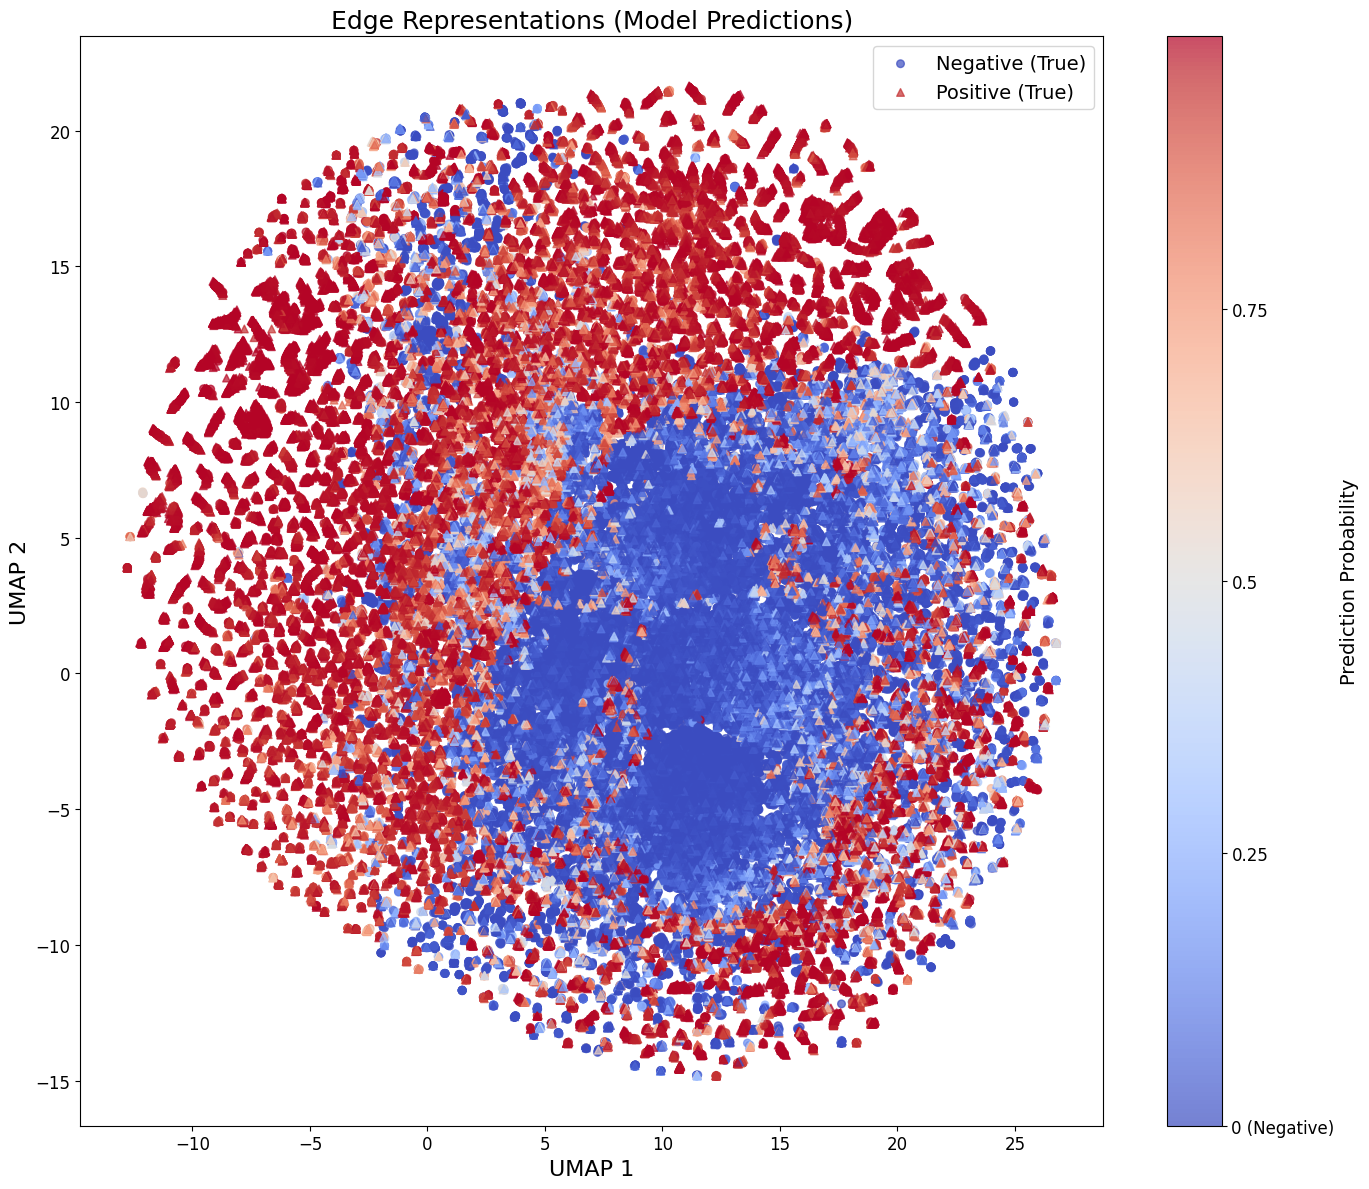

Total points: 261484
Class 0 (Negative) points: 130742
Class 1 (Positive) points: 130742


In [66]:
# plot_edge_representations(x_dict, edge_label_index, edge_label, method='umap', subsample_size=None)

##### TRY PCA+TSNE 

In [25]:
# import numpy as np
# import matplotlib.pyplot as plt
# import umap
# import torch
# import warnings
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# def plot_edge_representations(x_dict, edge_label_index, edge_label, n_components=2, method='umap', subsample_size=10000):
#     # Get node embeddings
#     x_drug, x_se = x_dict['drug'].cpu(), x_dict['side_effect'].cpu()
#     edge_label_index, edge_label = edge_label_index.cpu(), edge_label.cpu()
    
#     # Compute edge representations (Hadamard product)
#     edge_feat_drug = x_drug[edge_label_index[0]]
#     edge_feat_se = x_se[edge_label_index[1]]
#     edge_representations_hadamard = edge_feat_drug * edge_feat_se
    
#     # Compute sum and apply sigmoid for predictions
#     edge_sum = torch.sum(edge_representations_hadamard, dim=-1)
#     edge_predictions = torch.sigmoid(edge_sum)
    
#     # Convert to numpy
#     edge_representations_hadamard = edge_representations_hadamard.detach().numpy()
#     edge_predictions = edge_predictions.detach().numpy()
#     edge_labels = edge_label.numpy()
    
#     # Subsample if needed
#     if subsample_size is not None and edge_representations_hadamard.shape[0] > subsample_size:
#         indices = np.random.choice(edge_representations_hadamard.shape[0], subsample_size, replace=False)
#         edge_representations_hadamard = edge_representations_hadamard[indices]
#         edge_predictions = edge_predictions[indices]
#         edge_labels = edge_labels[indices]
    
#     # # Standardize the features
#     # scaler = StandardScaler()
#     # edge_representations_scaled = scaler.fit_transform(edge_representations_hadamard)
#     edge_representations_scaled = edge_representations_hadamard
    
#     # Dimensionality reduction
#     if method == 'pca':
#         reducer = PCA(n_components=n_components)
#         x_label, y_label = "Component1", "Component2"
#     elif method == 'tsne':
#         reducer = TSNE(
#             method='barnes_hut', angle=0.5,
#                 n_components=2,
#                 perplexity=50,
#                 learning_rate='auto',
#                 n_iter=2000,
#                 early_exaggeration=20,
#                 init='pca',
#                 metric='cosine',
#                 random_state=42,
#                 n_jobs=-1  # Use all available cores
#             )
#         x_label, y_label = "t-SNE Component 1", "t-SNE Component 2"
#     elif method == 'umap':
#         reducer = umap.UMAP(
#             n_components=n_components,
#             n_neighbors=12,
#             min_dist=0.4,
#             metric='correlation',
#             random_state=29,
#             # low_memory=True
#         )
#         x_label, y_label = "UMAP 1", "UMAP 2"
#     else:
#         raise ValueError("Method must be either 'pca', 'tsne', or 'umap'")
    
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", category=UserWarning)
#         edge_representations_2d = reducer.fit_transform(edge_representations_scaled)
    
#     pos_mask = edge_labels == 1
#     neg_mask = edge_labels == 0
    
#     # Plotting Model Predictions
#     plt.figure(figsize=(14, 12))
    
#     # Use a colormap that transitions from blue to red
#     cmap = plt.cm.coolwarm
    
#     plt.scatter(edge_representations_2d[neg_mask, 0], edge_representations_2d[neg_mask, 1], 
#                 c=edge_predictions[neg_mask], marker='o', s=30, alpha=0.7, label='Negative (True)', cmap=cmap)
#     plt.scatter(edge_representations_2d[pos_mask, 0], edge_representations_2d[pos_mask, 1], 
#                 c=edge_predictions[pos_mask], marker='^', s=30, alpha=0.7, label='Positive (True)', cmap=cmap)
    
    
#     plt.title('Edge Representations (Model Predictions)', fontsize=18)
#     plt.xlabel(x_label, fontsize=16)
#     plt.ylabel(y_label, fontsize=16)
#     plt.legend(fontsize=14, loc='best')
    
#     plt.tick_params(axis='both', which='major', labelsize=12)
    
#     # Add colorbar with custom ticks
#     cbar = plt.colorbar(ticks=[0, 0.25, 0.5, 0.75, 1])
#     cbar.ax.set_yticklabels(['0 (Negative)', '0.25', '0.5', '0.75', '1 (Positive)'], fontsize=12)
#     cbar.set_label('Prediction Probability', fontsize=14)
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print statistics
#     print(f"Total points: {len(edge_labels)}")
#     print(f"Class 0 (Negative) points: {np.sum(edge_labels == 0)}")
#     print(f"Class 1 (Positive) points: {np.sum(edge_labels == 1)}")

# # Usage example
# # plot_edge_representations(x_dict, edge_label_index, edge_label, method='umap', subsample_size=10000)


/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


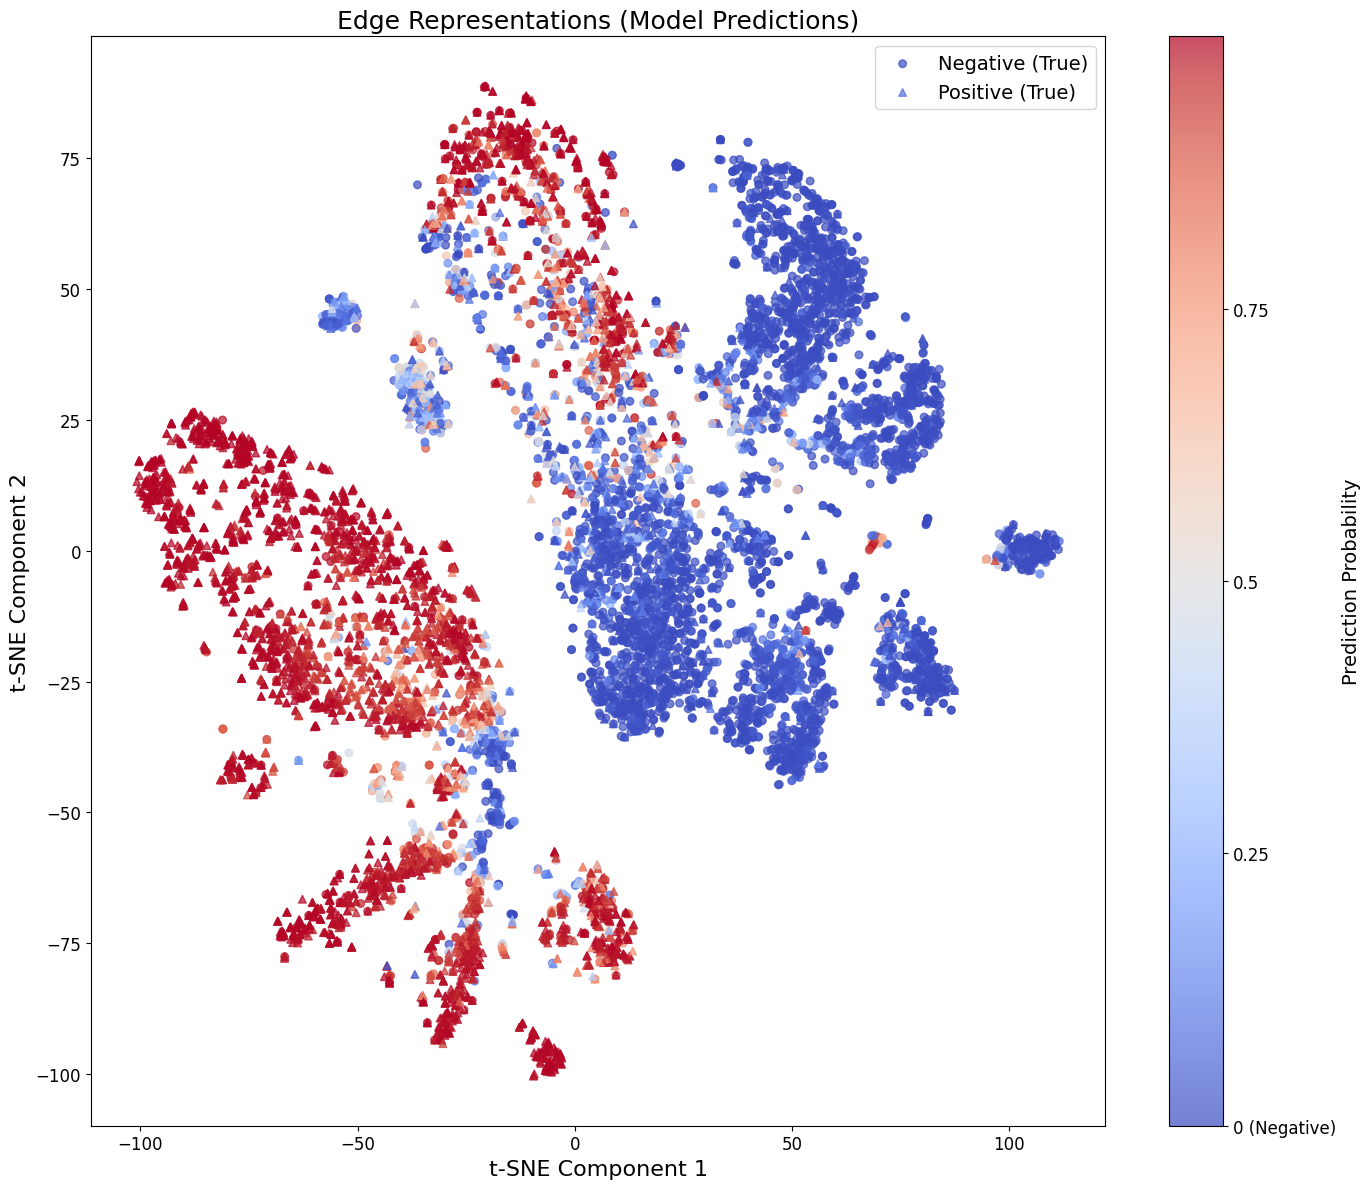

Total points: 10000
Class 0 (Negative) points: 5001
Class 1 (Positive) points: 4999


In [96]:
# plot_edge_representations(x_dict, edge_label_index, edge_label, method='tsne', subsample_size=10000)

### Final Viz using PCA+TSNE

#### Utils

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import umap
import torch
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_edge_representations(x_dict, edge_label_index, edge_label, n_components=2, subsample_size=5000):
    # Get node embeddings
    x_drug, x_se = x_dict['drug'].cpu(), x_dict['side_effect'].cpu()
    edge_label_index, edge_label = edge_label_index.cpu(), edge_label.cpu()
    
    # Compute edge representations (Hadamard product)
    edge_feat_drug = x_drug[edge_label_index[0]]
    edge_feat_se = x_se[edge_label_index[1]]
    edge_representations_hadamard = edge_feat_drug * edge_feat_se
    
    # Compute sum and apply sigmoid for predictions
    edge_sum = torch.sum(edge_representations_hadamard, dim=-1)
    edge_predictions = torch.sigmoid(edge_sum)
    
    # Convert to numpy
    edge_representations_hadamard = edge_representations_hadamard.detach().numpy()
    edge_predictions = edge_predictions.detach().numpy()
    edge_labels = edge_label.numpy()
    
    # Subsample if needed
    if subsample_size is not None and edge_representations_hadamard.shape[0] > subsample_size:
        indices = np.random.choice(edge_representations_hadamard.shape[0], subsample_size, replace=False)
        edge_representations_hadamard = edge_representations_hadamard[indices]
        edge_predictions = edge_predictions[indices]
        edge_labels = edge_labels[indices]
    
    # Standardize the features
    # scaler = StandardScaler()
    # edge_representations_scaled = scaler.fit_transform(edge_representations_hadamard)
    edge_representations_scaled = edge_representations_hadamard
    
    
    # # Step 1: PCA
    pca = PCA(
            n_components=100,
            svd_solver='randomized',  # Efficient for large datasets
            random_state=42,  # For reproducibility
            # iterated_power=5,  # Increase for potentially better accuracy, at the cost of speed
            whiten=False  # Set to True if you want to normalize the variance of components
        )

    reduced_data = pca.fit_transform(edge_representations_scaled)
    # reduced_data = edge_representations_scaled
    
    # Step 2: t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=10,
        learning_rate='auto',
        n_iter=300,
        early_exaggeration=20,
        init='pca',
        metric='cosine', #'cosine',
        random_state=42,
        n_jobs=-1
    )
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        edge_representations_2d = tsne.fit_transform(reduced_data)
    
    pos_mask = edge_labels == 1
    neg_mask = edge_labels == 0
    
    # Plotting Model Predictions
    plt.figure(figsize=(14, 12))
    
    # Use a colormap that transitions from blue to red
    cmap = plt.cm.coolwarm
    
    scatter_neg = plt.scatter(edge_representations_2d[neg_mask, 0], edge_representations_2d[neg_mask, 1], 
                              c=edge_predictions[neg_mask], marker='o', s=30, alpha=0.7, label='Negative (True)', cmap=cmap)
    scatter_pos = plt.scatter(edge_representations_2d[pos_mask, 0], edge_representations_2d[pos_mask, 1], 
                              c=edge_predictions[pos_mask], marker='^', s=30, alpha=0.7, label='Positive (True)', cmap=cmap)
    
    plt.title('Edge Representations (Model Predictions)', fontsize=18)
    plt.xlabel("t-SNE Component 1", fontsize=16)
    plt.ylabel("t-SNE Component 2", fontsize=16)
    plt.legend(fontsize=14, loc='best')
    
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Add colorbar with custom ticks
    cbar = plt.colorbar(scatter_pos, ticks=[0, 0.25, 0.5, 0.75, 1])
    cbar.ax.set_yticklabels(['0 (Negative)', '0.25', '0.5', '0.75', '1 (Positive)'], fontsize=12)
    cbar.set_label('Prediction Probability', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Total points: {len(edge_labels)}")
    print(f"Class 0 (Negative) points: {np.sum(edge_labels == 0)}")
    print(f"Class 1 (Positive) points: {np.sum(edge_labels == 1)}")

# Usage example
# plot_edge_representations(x_dict, edge_label_index, edge_label, subsample_size=10000)


#### TSNE on sample data

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


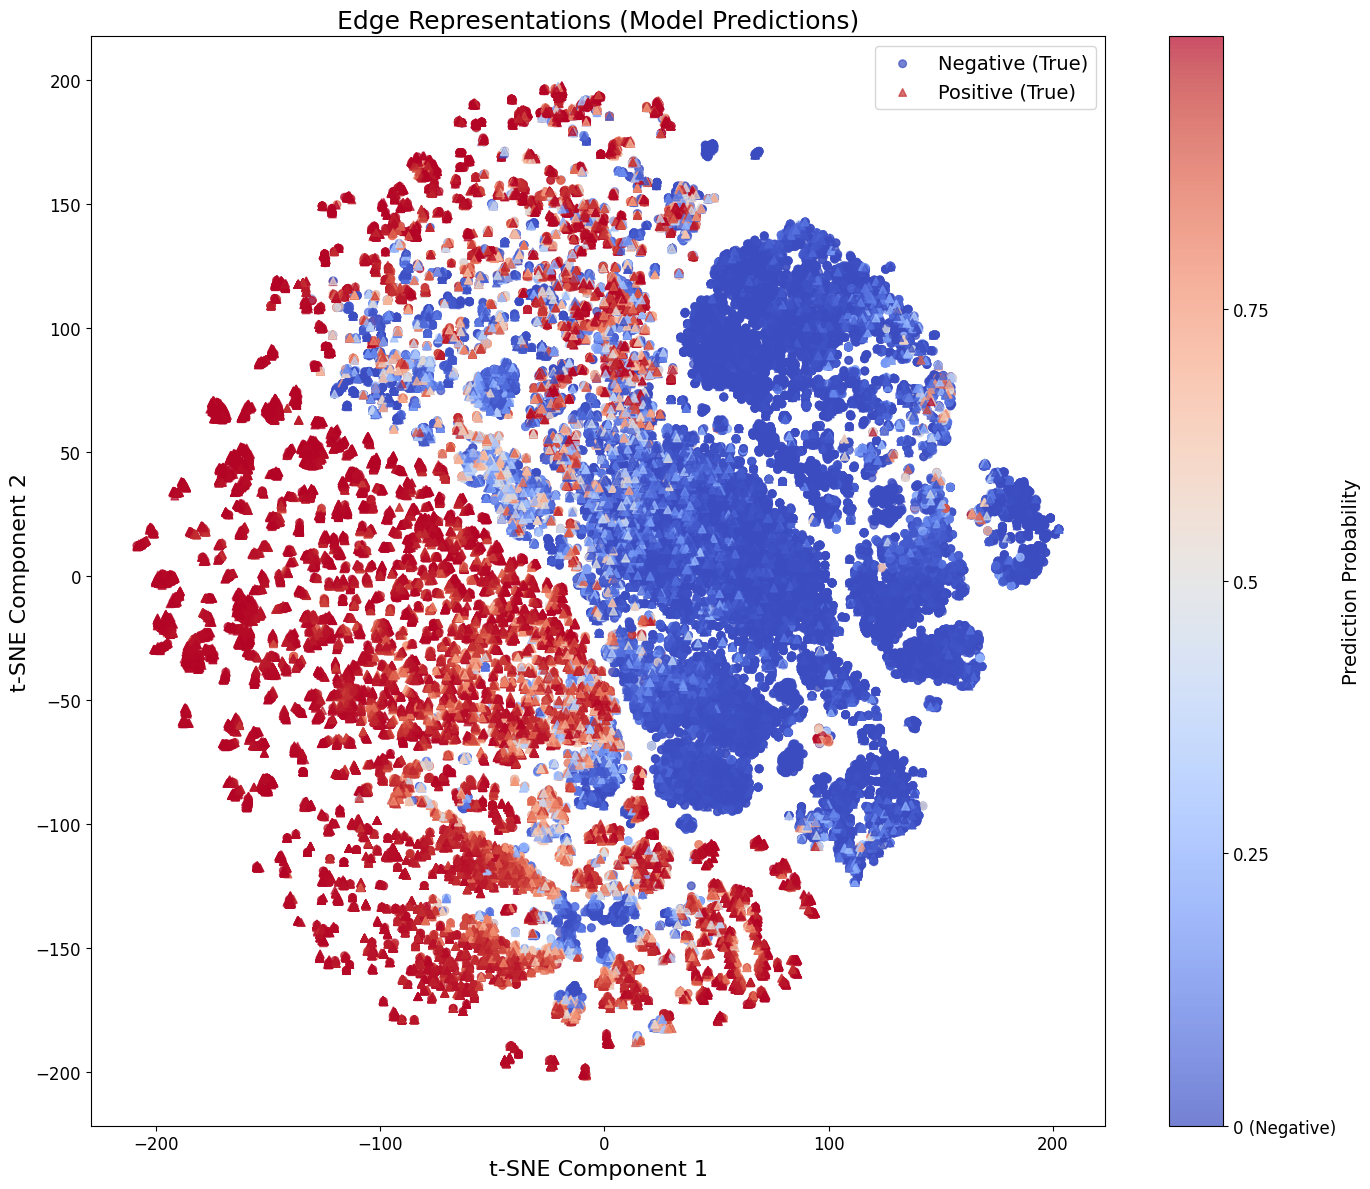

Total points: 100000
Class 0 (Negative) points: 50250
Class 1 (Positive) points: 49750


In [ ]:
plot_edge_representations(x_dict, edge_label_index, edge_label, subsample_size=100000)

#### TSNE Full Data

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


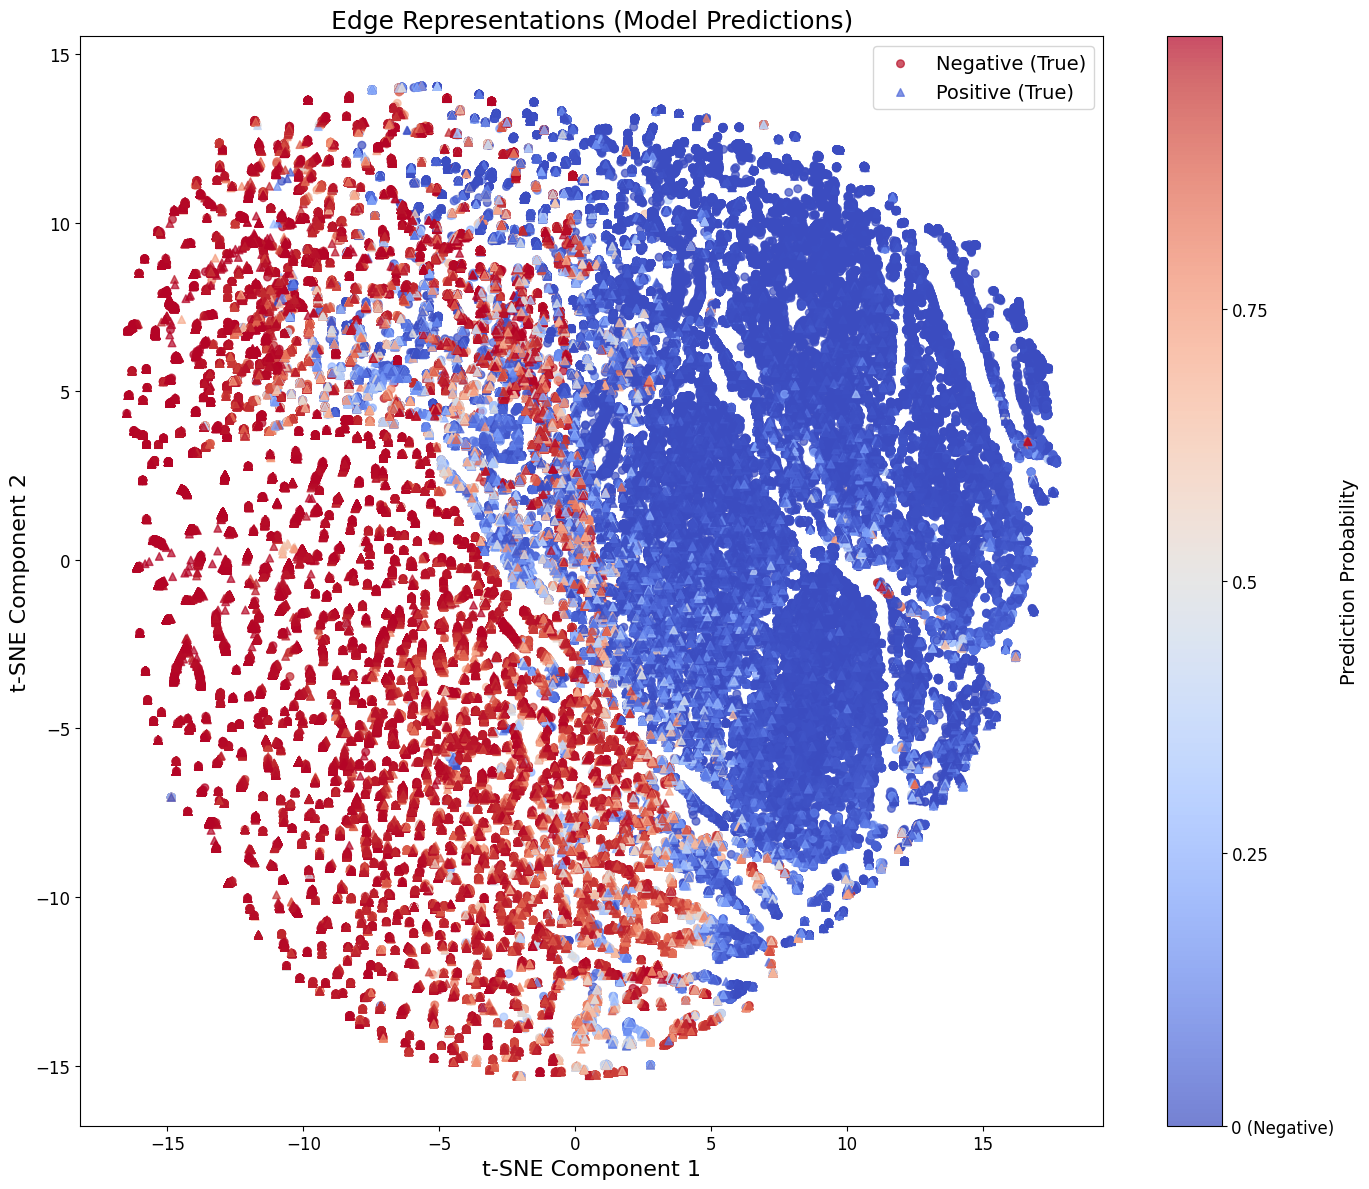

Total points: 261484
Class 0 (Negative) points: 130742
Class 1 (Positive) points: 130742


In [27]:
plot_edge_representations(x_dict, edge_label_index, edge_label, subsample_size=None)

### Prediction Analysis

In [133]:
x_drug, x_se = x_dict['drug'].cpu(), x_dict['side_effect'].cpu()
edge_label_index, edge_label = edge_label_index.cpu(), edge_label.cpu()

# Compute edge representations (Hadamard product)
edge_feat_drug = x_drug[edge_label_index[0]]
edge_feat_se = x_se[edge_label_index[1]]
edge_representations_hadamard = edge_feat_drug * edge_feat_se

# Compute sum and apply sigmoid for predictions
edge_sum = torch.sum(edge_representations_hadamard, dim=-1)
edge_predictions = torch.sigmoid(edge_sum)

# Convert to numpy
edge_representations_hadamard = edge_representations_hadamard.detach().numpy()
edge_predictions = edge_predictions.detach().numpy()
edge_labels = edge_label.numpy()


In [134]:
edge_label_index

tensor([[ 717,  680,  114,  ...,  989,  241,  215],
        [ 360,  897,  732,  ..., 2034, 2959,  857]])

In [135]:
# sorted decreasing prediction value for negative sample edges
srt_index = np.argsort(-edge_predictions[edge_labels==0])
srt_index

array([ 85922, 130080,  92175, ...,  21489,  51255,  79281])

In [136]:
# edge_label_index for negative sample in decresing order of prediction
srt_edge_label_index = edge_label_index[:, srt_index]
srt_edge_label_index

tensor([[ 389,  612,  767,  ...,  455,   34,   59],
        [  81,  395,  755,  ..., 4807, 1490, 2359]])

#### Reverse valid idse confirmed negative samples existence

In [137]:
dbid_name_map = dict(pd.read_csv("../raw_data/idse-data/drugs.txt", sep="\t", header=None, names=['drugbank_id', 'drug_name']).values)
name_dbid_map = {v:k  for k, v in dbid_name_map.items()}

In [138]:
seid_name_map = dict(pd.read_csv("../raw_data/idse-data/sideeffects.txt", sep="\t", header=None, names=['se_id', 'se_name']).values)
name_seid_map = {v:k for k, v in seid_name_map.items()}

In [139]:
confirmed_pairs = [('Ibuprofen', 'Body temperature increased'),
                   ('Lurasidone', 'Hypersensitivity'),
                   ('Iodixanol', 'Hypersensitivity'),
                   ('Valdecoxib', 'Oedema'),
                   ('Fluoxetine', 'Oedema'),
                   ('Mepyramine', 'Sensitisation'),
                   ('Bortezomib', 'Somnolence'),
                   ('Ofloxacin', 'Convulsion'),
                   ('Busulfan', 'Cardiac failure'),
                   ('Sitaxentan', 'Gastritis'),
                   ('Pioglitazone', 'Dermatitis'),
                   ('Quetiapine', 'Oedema'),
                   ('Tacrolimus', 'Cerebrovascular accident'),
                   ('Doxapram', 'Vomiting'),
                   ('Posaconazole', 'Palpitations'),
                   ('Alosetron', 'Diarrhoea'),
                   ('Pramipexole', 'Arrhythmia'),
                   ('Zalcitabine', 'Paraesthesia'),
                   ('Zalcitabine', 'Face oedema'),
                   ('Pantoprazole', 'Hypokalaemia'),
                   ('Fentanyl', 'Dry skin'),
                   ('Oxcarbazepine', 'Anaemia')
                   ]

In [140]:
drug_name, se_name = zip(*confirmed_pairs)


In [141]:
drug_idx = [DB_TO_ID_DICT[name_dbid_map[drug]] for drug in drug_name]
se_idx = [MEDRAID_TO_ID_DICT[name_seid_map[se]] for se in se_name]

In [142]:
db_emb = x_dict['drug'][drug_idx]
se_emb = x_dict['side_effect'][se_idx]

In [143]:
edge_repr = db_emb * se_emb
    
# Compute sum and apply sigmoid for predictions
edge_sum_ = torch.sum(edge_repr, dim=-1)
edge_pred = torch.sigmoid(edge_sum_)
edge_pred

tensor([0.9964, 0.9948, 0.9953, 0.9967, 0.9979, 0.0014, 0.9987, 0.9975, 0.9505,
        0.9966, 0.9957, 0.9982, 0.9719, 0.9780, 0.9987, 0.9995, 0.9974, 0.9950,
        0.9887, 0.9719, 0.9647, 0.9906], device='cuda:0')

#### Dissocial Analysis

In [144]:
def fetch_all_known(match_id, known_edge_index, node="drug"):
    fetch_idx = 1 if node == "drug" else 0
    match_idx = 0 if node == "drug" else 1
    retrived_ids = known_edge_index[fetch_idx][known_edge_index[match_idx]==match_id]
    return retrived_ids.numpy()

In [171]:
def dissocial_analysis(data, x_dict, node="drug", n=30):
    known_edge_index = data[('drug', 'known', 'side_effect')]['edge_index']
    idx = 0 if node == 'drug' else 1
    node_counter = Counter(known_edge_index[idx].numpy()).most_common()
    node_with_least, _ = zip(*node_counter[:-n-1:-1])

    node_with_least_known_index = {node_id: fetch_all_known(node_id, known_edge_index, node=node) for node_id in node_with_least}
    node_with_least_emb = x_dict[node][node_with_least, :]
    
    other_node_type = "side_effect" if node == "drug" else "drug"
    all_other_node_type_emb = x_dict[other_node_type]

    # Compute all predictions
    predictions = torch.sigmoid(torch.sum(node_with_least_emb.unsqueeze(1) * all_other_node_type_emb.unsqueeze(0), dim=2))
    predictions_int = (predictions>0.5).int()
    predictions_int = predictions_int.cpu().numpy() 

    # Get the known associated other node type as lists
    
    known_other_node_type_lists = list(node_with_least_known_index.values())

    # Create a mask for known side effects
    mask = np.zeros_like(predictions_int, dtype=bool)
    for i, known_edge in enumerate(known_other_node_type_lists):
        mask[i, known_edge] = True

    # Calculate positive sample hit rates
    positive_hit_rates = np.sum(predictions_int * mask, axis=1) / np.sum(mask, axis=1)

    # Calculate real sample hit rates
    correct_predictions = (predictions_int == mask.astype(int))
    real_hit_rates = np.mean(correct_predictions, axis=1)

    # Plotting
    plt.figure(figsize=(16, 8))

    # Plot positive hit rates
    plt.plot(range(len(node_with_least)), positive_hit_rates, marker='o', linestyle='-', markersize=8, color='blue', label='Positive Sample Hit Rate')

    # Plot real hit rates
    plt.plot(range(len(node_with_least)), real_hit_rates, marker='s', linestyle='-', markersize=8, color='red', label='Real Sample Hit Rate')

    # Set x-ticks to drug IDs
    plt.xticks(range(len(node_with_least)), node_with_least, rotation=90)

    # Labels and title
    plt.xlabel(f'{node}_id')
    plt.ylabel('Hit Rate')
    plt.title(f"{' '.join([w.title() if idx==0 else w for idx, w in enumerate(other_node_type.split('_'))])} prediction of dissocial {node}")

    # Add grid
    plt.grid(True)

    # Add legend
    plt.legend()

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()
    return node_with_least_known_index



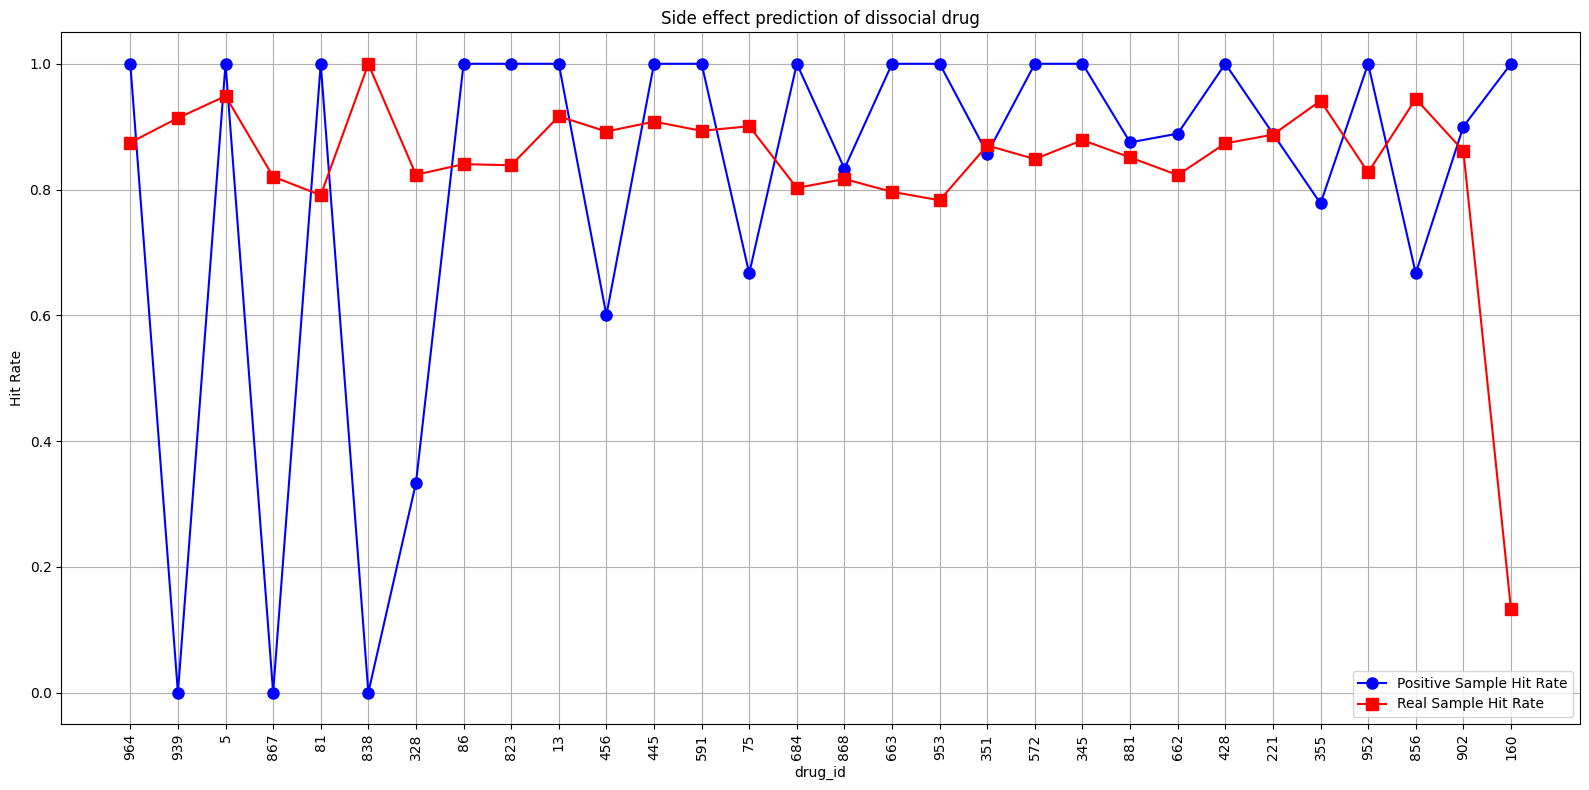

In [172]:
drug_dissocial_dict = dissocial_analysis(data, x_dict, node="drug", n=30)

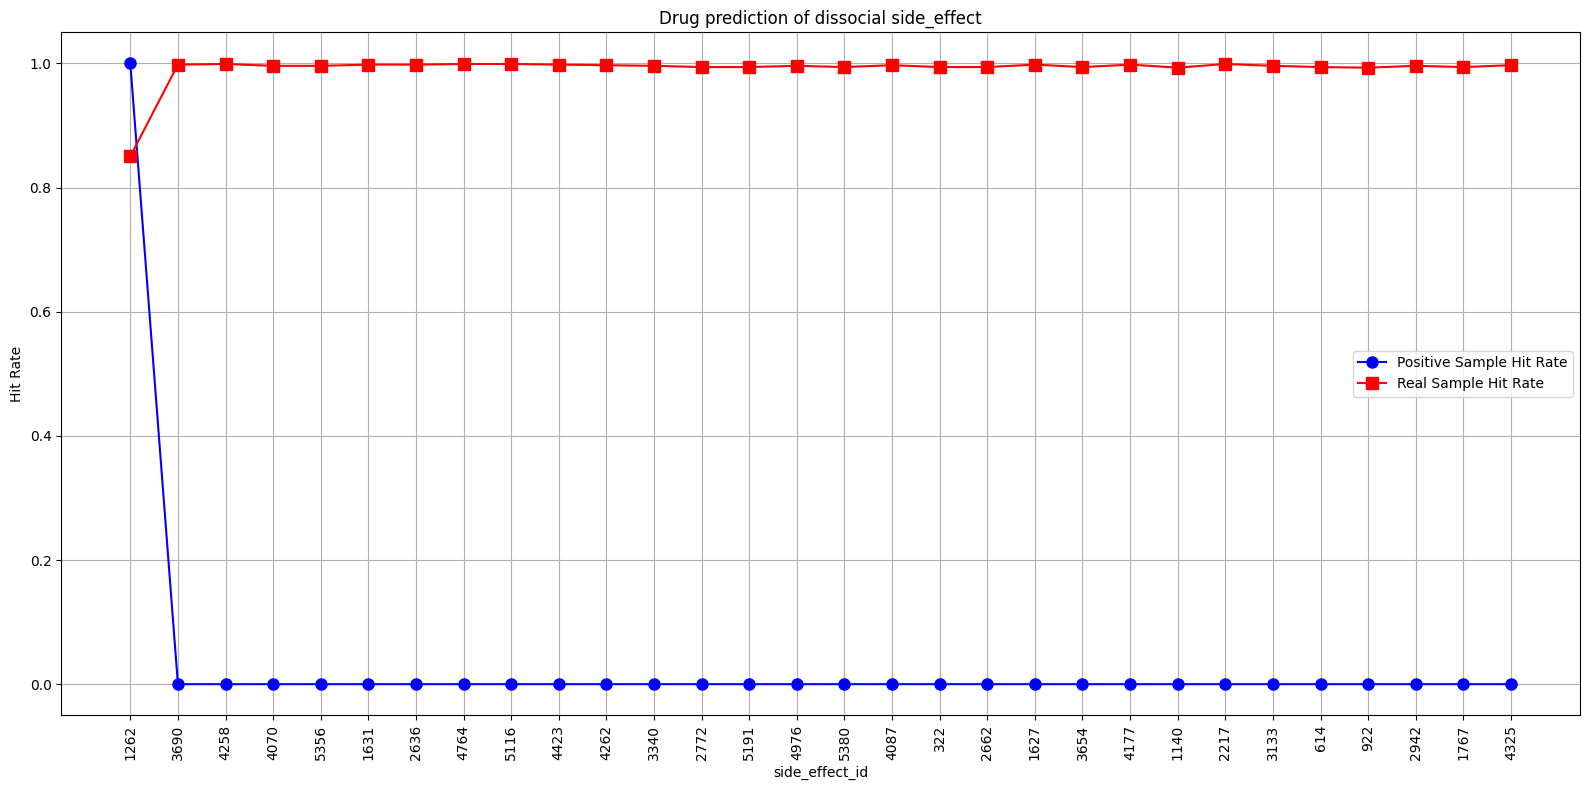

In [173]:
se_dissocial_dict = dissocial_analysis(data, x_dict, node="side_effect", n=30)

In [188]:
d_id_drug_dissocial_dict = list(drug_dissocial_dict.keys())
all_se_drug_dissocial_dict = list([val for val_list in drug_dissocial_dict.values() for val in val_list])
# d_id_drug_dissocial_dict, all_se_drug_dissocial_dict

In [187]:
se_id_drug_dissocial_dict = list(se_dissocial_dict.keys())
all_drug_se_dissocial_dict = list([val for val_list in se_dissocial_dict.values() for val in val_list])
# se_id_drug_dissocial_dict, all_drug_se_dissocial_dict

In [186]:
# drug disccocial still performs meanig drug with very few side effects are predicted
# that means few drugs have very few side effects
# but these side effects still might occur for other drugs which have lot many side effects
set(d_id_drug_dissocial_dict ).intersection(set(all_drug_se_dissocial_dict))

set()

In [185]:
# so for all the se disscial ids we check if we have such se ids in my drug dissocial list and found no intersection
# meaning the side effect available in side effect dissocial list are very rare
# most of the 30 - side effect with single drug associated comes from handful of drugs
set(all_se_drug_dissocial_dict).intersection(set(se_id_drug_dissocial_dict )), len(list(set(all_drug_se_dissocial_dict)))

(set(), 10)